In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
import seaborn as sns
import umap
import hdbscan

/Users/lassemiddendorf/anaconda3/envs/GBE_MacOS/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lassemiddendorf/anaconda3/envs/GBE_MacOS/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lassemiddendorf/anaconda3/envs/GBE_MacO

## Build dataset for clustering

In [2]:
#Build dataset
dn = pd.read_csv("Data/denovo_data_final.csv", index_col=0)


rd = pd.read_csv("Data/random_data_final.csv", index_col=0)


cd = pd.read_csv("Data/cd_code_data_final.csv", index_col=0).dropna()

cd = cd.drop([
    "Uniprot ID",
    "Gene Name",
    "Name",
    "Biomolecular condensate count",
    "Synthetic condensate count",
    "Species",
    "PICNIC GO score",
    "Proteins",
    "Genes",
    "Organism",
    "Organism ID",
    "CD-Code included",
    "max_confidence"
], axis=1)

cd["seqLen"] = cd["sequence"].apply(lambda x: len(x))
cd["correctly_predicted"] = cd["picnic_score"].apply(lambda x: True if x >= 0.5 else False)

df = pd.concat([dn, rd, cd], axis=0).reset_index(drop=True)

#assign class labels
df["class"] = 0

def assign_class(id):
    try:
        if "droso" in id:
            return "denovo"
        elif "rand" in id:
            return "random"
        else:
            return "cd_code"
    except:
        return np.nan

df["class"] = df["id"].apply(lambda x: assign_class(x))
df["correctly_predicted"].fillna("Unkown", inplace=True)

In [3]:
#sequence features that were removed because they are unlikely to be found in de novo proteins
feats_to_remove = [
    "CLV_C14_Caspase3-7",
    "DEG_APCC_KENBOX_2",
    "DEG_Kelch_Keap1_1",
    "DEG_SCF_TRCP1_1",
    "DOC_ANK_TNKS_1",
    "DOC_CYCLIN_RxL_1",
    "DOC_MAPK_gen_1",
    "DOC_MAPK_JIP1_4",
    "DOC_MAPK_MEF2A_6",
    "DOC_MAPK_NFAT4_5",
    "DOC_PP1_RVXF_1",
    "DOC_PP2A_B56_1",
    "DOC_PP4_FxxP_1",
    "DOC_WW_Pin1_4",
    "aromatic_spacing*", #contains multipe entries with Nan
    "omega_aromatic*", #contains multipe entries with Nan
    "kappa*" #contains multipe entries with Nan
]

df = df.drop(feats_to_remove, axis=1)

In [4]:
#Remove length independent features and non numerical features prior to normalization
length_independent_feats = [
    "net_charge",
    "WF_complexity",
    "KL_hydropathy",
    "isoelectric_point",
    "FCR",
    "ED_ratio",
    "RK_ratio",
    "SCD",
    "omega*",
    "sequence",
    "seqLen",
    "age",
    "picnic_score",
    "id",
    "class",
    "correctly_predicted"
]

df_length_dependent = df.drop(length_independent_feats, axis=1)

#Normalize length dependent features based on sequence length

df_length_dependent = df_length_dependent.apply(lambda x: x / df["seqLen"])

#add back length independent features
df = df.drop(df_length_dependent.columns, axis=1)
df_length_dependent["id"] = df["id"]
df = pd.merge(df, df_length_dependent, on="id")


## Clustering based on sequence features

In [5]:
# Perfrom UMAP for HDBSCAN

#remove non numerical features
vals_for_clustering = df.drop(["id", "class", "correctly_predicted", "picnic_score","sequence", "age"], axis=1).values

umap_hdbscan_embeddigns = umap.UMAP(n_neighbors=15, min_dist=0.0, n_components=5, random_state=42).fit_transform(vals_for_clustering)
lables = hdbscan.HDBSCAN(min_samples=50, min_cluster_size=100).fit_predict(umap_hdbscan_embeddigns)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
#umap
u = umap.UMAP(n_components=2, random_state=1, n_neighbors=15, min_dist=0.0, n_epochs=30000)
umap_vals = u.fit_transform(vals_for_clustering)

## Analysis of cluster composition

Text(0, 0.5, 'UMAP2')

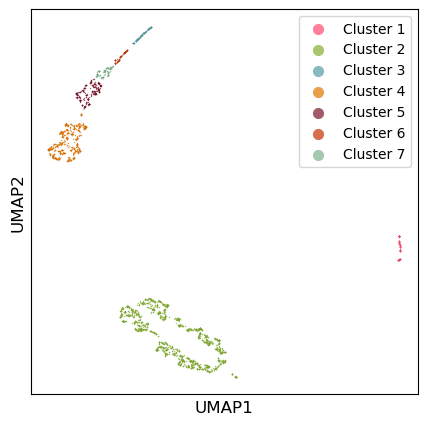

In [7]:
umap_df = pd.DataFrame(umap_vals, columns=["umap1", "umap2"])
umap_df["class"] = df["class"]
umap_df["age"] = df["age"]
umap_df["id"] = df["id"]
umap_df["picnic_score"] = df["picnic_score"]
umap_df["correctly_predicted"] = df["correctly_predicted"]
umap_df["cluster"] = lables
umap_df = umap_df[umap_df["class"] != "random"]

colors = ["#ff4c6e", "#84ae30", "#579ca3", "#e07600", "#7c152a", "#ca3100", "#7fb38b"]

fig, ax = plt.subplots(figsize=(5, 5))

for i in sorted(umap_df.cluster.unique()):

    if i == -1:
        ax.scatter(umap_df[umap_df["cluster"] == i]["umap1"], umap_df[umap_df["cluster"] == i]["umap2"], s=1, alpha=0.7, c="lightgray", edgecolors="black", linewidths=0.01)
    else:
        ax.scatter(umap_df[umap_df["cluster"] == i]["umap1"], umap_df[umap_df["cluster"] == i]["umap2"], s=1, alpha=0.7, c=colors[i], edgecolors="black", linewidths=0.01, label=f"Cluster {i + 1}")


ax.legend(markerscale=8, fontsize=10)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel("UMAP1", fontsize=12)
ax.set_ylabel("UMAP2", fontsize=12)


/var/folders/9x/smcwc3jj20b87jkkkrgmlz7c0000gn/T/ipykernel_47088/1794014066.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,1,2,3,4,5,6,7])


Text(0, 0.5, 'Realtiv Cluster Composition')

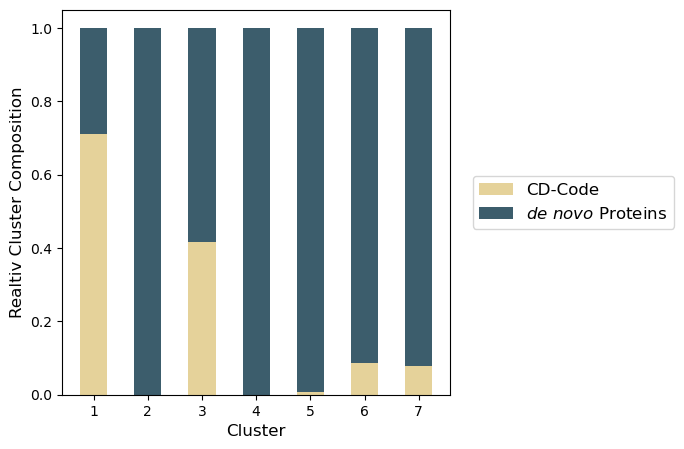

In [8]:
# Stacked bar grpah to show the fraction of protein classes in each cluster
cluster_counts = umap_df.groupby(["cluster", "class"]).size().reset_index(name="counts")



#calculate fraction of each class in each cluster
cluster_counts["fraction"] = np.nan

for cluster in cluster_counts["cluster"].unique():
    
    if len(cluster_counts[cluster_counts["cluster"] == cluster]) == 1:
        if cluster_counts[cluster_counts["cluster"] == cluster]["class"].values[0] == "cd_code":
            cluster_counts.loc[len(cluster_counts)] = [cluster, "denovo", 0, 0]
        else:
            cluster_counts.loc[len(cluster_counts)] = [cluster, "cd_code", 0, 0]
    
    try:
            cd_code_count = cluster_counts[(cluster_counts["cluster"] == cluster) & (cluster_counts["class"] == "cd_code")]["counts"].values[0]
            denovo_count = cluster_counts[(cluster_counts["cluster"] == cluster) & (cluster_counts["class"] == "denovo")]["counts"].values[0]

            fraction_cd_code = cd_code_count / (cd_code_count + denovo_count)
            fraction_denovo = denovo_count / (cd_code_count + denovo_count)

            cluster_counts.loc[(cluster_counts["cluster"] == cluster) & (cluster_counts["class"] == "cd_code"), "fraction"] = fraction_cd_code
            cluster_counts.loc[(cluster_counts["cluster"] == cluster) & (cluster_counts["class"] == "denovo"), "fraction"] = fraction_denovo
    except:
        cluster_counts.loc[(cluster_counts["cluster"] == cluster) & (cluster_counts["class"] == "denovo"), "fraction"] = 1


cluster_counts = cluster_counts.sort_values(by="cluster")
cluster_counts = cluster_counts[cluster_counts["cluster"] != -1] #remove noise cluster

#plot stacked bar graph
fig, ax = plt.subplots(figsize=(5, 5))

ax.bar(range(len(cluster_counts.cluster.unique())), cluster_counts[cluster_counts["class"] == "cd_code"]["fraction"].values, color="#e5d29aff", width=0.5, label="CD-Code")
ax.bar(range(len(cluster_counts.cluster.unique())), cluster_counts[cluster_counts["class"] == "denovo"]["fraction"].values, bottom=cluster_counts[cluster_counts["class"] == "cd_code"]["fraction"].values, color="#3c5d6c", width=0.5, label=r"$\it{de}$ $\it{novo}$ Proteins")

ax.set_xticklabels([0,1,2,3,4,5,6,7])
ax.legend(fontsize=12, loc="right", bbox_to_anchor=(1.6, 0.5))

ax.set_xlabel("Cluster", fontsize=12)
ax.set_ylabel("Realtiv Cluster Composition", fontsize=12)

## Influence of Age of on condensate formation potential 

In [9]:
#Assign age group for de novo proteins
def assign_Age_group(x):
    if x < 5:
        return 1
    elif x < 30:
        return 2
    else:
        return 3

umap_df["age_group"] = umap_df["age"].apply(lambda x: assign_Age_group(x))

In [10]:
high_confidence_denovos = umap_df[
    ((umap_df["cluster"] == 0) | (umap_df["cluster"] == 2)) &
    (umap_df["class"] == "denovo") &
    (umap_df["picnic_score"] >= 0.5)
]

In [15]:
high_confidence_denovos.to_csv("high_confidence_denovos.csv", index=False)

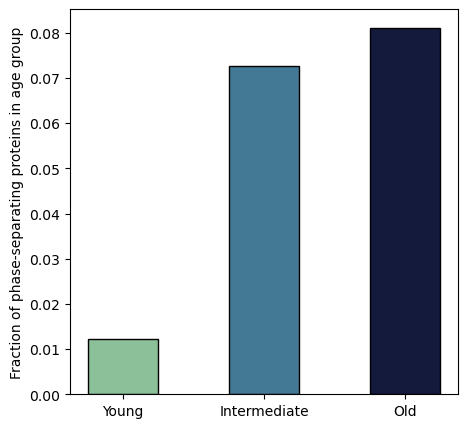

In [12]:
# bar plot to show the fraction per age group of all high confidence de novo proteins
fig, ax = plt.subplots(figsize=(5, 5))

colors = ["#8cc098", "#437995", "#141a3c"]
labels = ["Young", "Intermediate", "Old"]

sizes = [
    len(high_confidence_denovos[high_confidence_denovos["age_group"] == 1]) / len(umap_df[umap_df["age_group"] == 1]),
    len(high_confidence_denovos[high_confidence_denovos["age_group"] == 2]) / len(umap_df[umap_df["age_group"] == 2]),
    len(high_confidence_denovos[high_confidence_denovos["age_group"] == 3]) / len(umap_df[umap_df["age_group"] == 3])
]

ax.bar(labels, sizes, color=colors, width=0.5, edgecolor="black", linewidth=1)
ax.set_ylabel("Fraction of phase-separating proteins in age group", fontsize=10);



In [13]:
#Chi square test to test if the fraction of phase separating proteins in each age group is significantly different from the expected fraction
from scipy.stats import chisquare

f_exp = (umap_df[umap_df["class"] == "denovo"]["age_group"].value_counts().values / len(umap_df[umap_df["class"] == "denovo"])) * len(high_confidence_denovos)
f_obs = high_confidence_denovos["age_group"].value_counts().sort_index().values

chisquare(f_obs, f_exp).pvalue

2.4896888304502952e-54

In [14]:
f_exp

array([55.33546071,  4.90027922,  2.76426007])